In [261]:
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
titanic = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#The ticket number of the passenger are all unique and don't have a concrete format. 
#Therefore, no analysis could be done on the ticket number and thus is dropped.
#The cabin number has lots of missing data and they can't be easily imputed (no average cabin number). 
#Thus, we drop the column 'cabin'.
#The names of the passengers don't really determine much and most are unique. 
#Thus, no analysis can be done on their name and thus is dropped.
titanic = titanic.drop('Ticket', axis=1)
titanic = titanic.drop('Cabin', axis=1)
titanic = titanic.drop('Name', axis=1)
titanic

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,NaN,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


In [262]:
#We find the mean for age, rounded it for simplicity, then imputed any missing values in Age with mean imputation. 
titanic_meanAge = round(titanic['Age'].mean(), 1)
titanic['Age'].fillna(titanic_meanAge, inplace = True)
titanic
#It didn't seem important in our cleaning to think about outliers in the age as none of the entries had ages that
# seemed unreasonable.


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,29.7,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


In [263]:
#THIS IS A CELL THAT WAS DECIDED TO BE KEPT IN, SO AS TO SHOW OUR PROCESS IN DECIDING THAT Fare IS ULTIMATELY 
#DROPPED FROM OUR ANALYSIS

titanic_dropFares = pd.DataFrame(titanic)
#This loop removes all entries that have a fare of 0 or less for calculating the mean, since 
#those entries are presumed to be missing values due to their lack of value. 
#The calculated mean will be used to impute those entries.
for x in titanic_dropFares.index:
  if titanic_dropFares.loc[x, "Fare"] <= 0:
    titanic_dropFares.drop(x, inplace = True)

#Seperate dataframe into 3, spliting them across each ticket class x (['Pclass'] == x) because the ticket price is
#correlated to the ticket class the passenger purchased.
df1 = titanic[titanic['Pclass'] == 1]
df2 = titanic[titanic['Pclass'] == 2]
df3 = titanic[titanic['Pclass'] == 3]

#For each of the split dataframes, we found the 25th and 75th percentile of the variable Fare and then 
#found the difference to find the interquartile range.
#We calculate the Outliers with the formula:  Q3 + 1.5IQR AND Q1 - 1.5 IQR
q75, q25 = np.percentile (df1['Fare'], [75, 25])
iqr1 = q75 - q25
outlier_max1 = 1.5*iqr1 + q75
outlier_min1 = q25 - 1.5*iqr1
print('outlier max class 1: '+ str(outlier_max1))
print('outlier min class 1: '+ str(outlier_min1))

q75, q25 = np.percentile (df2['Fare'], [75, 25])
iqr2 = q75 - q25
outlier_max2 = 1.5*iqr2 + q75
outlier_min2 = q25 - 1.5*iqr2
print('outlier max class 2: '+ str(outlier_max2))
print('outlier min class 2: '+ str(outlier_min2))

q75, q25 = np.percentile (df3['Fare'], [75, 25])
iqr3 = q75 - q25
outlier_max3 = 1.5*iqr3 + q75
outlier_min3 = q25 - 1.5*iqr3
print('outlier max class 3: '+ str(outlier_max3))
print('outlier min class 3: '+ str(outlier_min3))

#All Fare = 0 entries are imputed with the mean of their respective ticket class
for x in df1.index:
    if df1.loc[x, "Fare"] == 0:
        titanic.loc[x,"Fare"]=titanic_averageFare['Fare'][1]
for x in df2.index:
    if df2.loc[x, "Fare"] == 0:
        titanic.loc[x,"Fare"]=titanic_averageFare['Fare'][2]
for x in df3.index:
    if df3.loc[x, "Fare"] == 0:
        titanic.loc[x,"Fare"]=titanic_averageFare['Fare'][3]
print(titanic)

outlier max class 1: 187.364075
outlier min class 1: -62.940125
outlier max class 2: 45.5
outlier min class 2: -6.5
outlier max class 3: 27.125
outlier min class 3: -3.875
     PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch     Fare  \
0              1         0       3    male  22.0      1      0   7.2500   
1              2         1       1  female  38.0      1      0  71.2833   
2              3         1       3  female  26.0      0      0   7.9250   
3              4         1       1  female  35.0      1      0  53.1000   
4              5         0       3    male  35.0      0      0   8.0500   
..           ...       ...     ...     ...   ...    ...    ...      ...   
886          887         0       2    male  27.0      0      0  13.0000   
887          888         1       1  female  19.0      0      0  30.0000   
888          889         0       3  female  29.7      1      2  23.4500   
889          890         1       1    male  26.0      0      0  30.0000   
890

        PassengerId  Survived  Sex  Age  SibSp  Parch  Fare  Embarked
Pclass                                                               
1               216       216  216  216    216    216   216       214
2               184       184  184  184    184    184   184       184
3               491       491  491  491    491    491   491       491
Before removing outliers: 
          PassengerId  Pclass        Age     SibSp     Parch       Fare
Survived                                                               
0          410.300000     1.0  40.896250  0.287500  0.300000  64.684007
1          491.772059     1.0  34.784706  0.492647  0.389706  95.608029
          PassengerId  Pclass        Age     SibSp     Parch       Fare
Survived                                                               
0          452.123711     2.0  33.267010  0.319588  0.144330  19.412328
1          439.080460     2.0  26.076207  0.494253  0.643678  22.055700
          PassengerId  Pclass        Age     Si

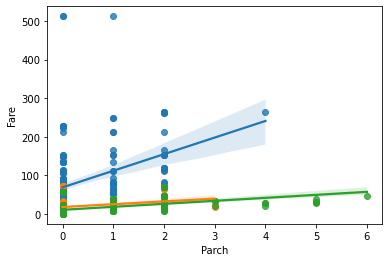

In [264]:
#THIS IS A CELL THAT WAS DECIDED TO BE KEPT IN, SO TO SHOW OUR PROCESS IN DECIDING THAT Fare IS ULTIMATELY 
#DROPPED FROM OUR ANALYSIS

#Count the entries by Pclass
titanic_count = titanic.groupby(by = 'Pclass').count()
print(titanic_count)
#This was an earlier attempt to see how many outliers there are by dropping them.
#for x in df1.index:
#    if df1.loc[x, "Fare"] >= outlier_max1:
#        titanic = titanic.drop(x)
#    if df1.loc[x, "Fare"] <= outlier_min1:
#        titanic = titanic.drop(x)
#print(titanic)           

#Removed 20 entries (There are 216 entries, so removing 20/216 = 9.259% of the 1st ticket class population)

#for x in df2.index:
#    if df2.loc[x, "Fare"] >= outlier_max2:
#        titanic = titanic.drop(x)
#    if df2.loc[x, "Fare"] <= outlier_min2:
#        titanic = titanic.drop(x)
#print(titanic)

#Removed 7 entries (There are 184 entries, so removing 7/184 = 3.8% of the 2nd ticket class population)

#for x in df3.index:
#    if df3.loc[x, "Fare"] >= outlier_max3:
#        titanic = titanic.drop(x)
#    if df3.loc[x, "Fare"] <= outlier_min3:
#        titanic = titanic.drop(x)
#print(titanic)

#Removed 52 entries (There are 491 entries, so removing 52/491 = 10.59% of the 3rd ticket class population)

#It was found that there is a large amount of outliers, especially the 1st and 3rd ticket classes. Looking back at the dataset, 
# it seemed like the fare was also tied to the Parch attribute, instead of just class. So, we graphed it and 
# it was true.
sea.regplot(x = df1['Parch'], y = df1['Fare'])
sea.regplot(x = df2['Parch'], y = df2['Fare'])
sea.regplot(x = df3['Parch'], y = df3['Fare'])

#We check how dropping the outliers affects the mean value of the attribute Parch and found that there was 
# a significant decrease in the mean of the attribute. 
print("Before removing outliers: ")
titanic_survived = df1.groupby(by = 'Survived').mean()
print(titanic_survived)
titanic_survived = df2.groupby(by = 'Survived').mean()
print(titanic_survived)
titanic_survived = df3.groupby(by = 'Survived').mean()
print(titanic_survived)

for x in df1.index:
    if df1.loc[x, "Fare"] >= outlier_max1 or df1.loc[x, "Fare"] <= outlier_min1:
        df1 = df1.drop(x)
for x in df2.index:
    if df2.loc[x, "Fare"] >= outlier_max2 or df2.loc[x, "Fare"] <= outlier_min2:
        df2 = df2.drop(x)
for x in df3.index:
    if df3.loc[x, "Fare"] >= outlier_max3 or df3.loc[x, "Fare"] <= outlier_min3:
        df3 = df3.drop(x)
print("After removing outliers: ")
titanic_survived = df1.groupby(by = 'Survived').mean()
print(titanic_survived)
titanic_survived = df2.groupby(by = 'Survived').mean()
print(titanic_survived)
titanic_survived = df3.groupby(by = 'Survived').mean()
print(titanic_survived)

#As we want to have the model be trained with a more varied value of the attribute Parch and that other than 
# being affected Parch, Fare seemed to be similar to Pclass in function, we decided to not drop the outliers of Fare, 
# but instead dropping the Fare attribute in total.
# titanic = titanic.drop('Fare', axis=1)
# This will be done after the attributes are compared to each other.
#WITH THIS, THE DATA IS DEEMED TO BE CLEANED!

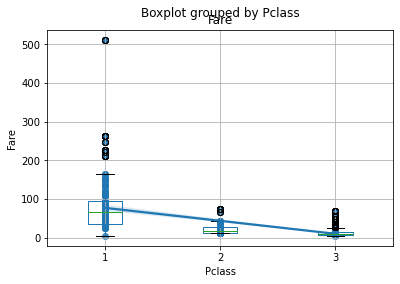

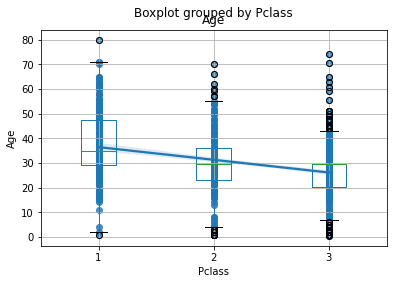

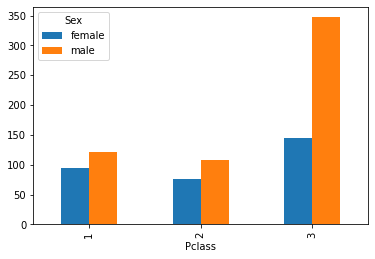

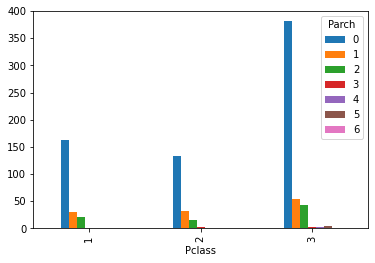

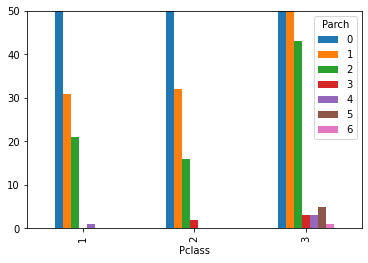

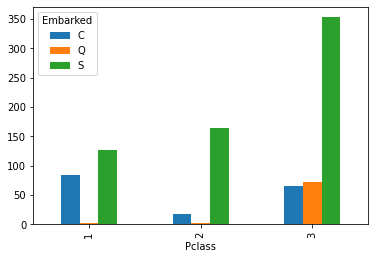

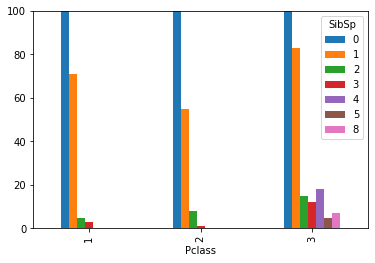

In [265]:
#The ticket class of a passenger seemed to be a good indicator of their socio-economic status as fare was
# correlated with their ticket class. The ticket class 1 was the most expensive and the ticket class 3
# 3 was the least expensive.
titanic.boxplot(column = 'Fare', by = 'Pclass')
sea.regplot(x = titanic['Pclass'], y = titanic['Fare'])


#To see how age is affected by Pclass, a box and whisker plot and a regression line from a scatter plot
# with the same attributes (Pclass vs. Age) is drawn. They both show a decrease in the age the lesser 
# socio-economic status. This could be a result of younger people having less time working and thus poorer.
titanic.boxplot(column = 'Age', by = 'Pclass')
sea.regplot(x = titanic['Pclass'], y = titanic['Age'])

#To see how gender is affected by Pclass, they were grouped together by Pclass and Sex and then plotted by count 
# as a bar graph. In the bar graph, the females were always lesser than the males, regardless of the Pclass. However,
# it seems like there is a significant number of males compared to females in the 3rd Pclass, almost twice the number
# of males compared to number females.

titanic_gender=titanic.groupby(['Pclass','Sex']).size()
titanic_gender=titanic_gender.unstack()
titanic_gender.plot(kind='bar')

#To see how the number of parents and children are affected by Pclass, a bar graph similar in implementation to 
# the Sex vs Pclass is done.
titanic_parch=titanic.groupby(['Pclass', 'Parch']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')

#The number of Parch being 0 is very prominent compared to every other number for the attribute Parch. The number 
# of Parch that werte greater than 0 was so small compared that the same graph was made, but the y limit was set to 50
# ,so the other Parch attribute counts could be looked at. Overall, it seemed like a Power Law Distribution.
# Regardless of Pclass, most have Parch = 0, 1, or 2. Then, there are the very few that have Parch > 2.4
titanic_parch=titanic.groupby(['Pclass', 'Parch']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')
ax = ax.set_ylim(0,50)

#Where the passenger embarked vs. their Pclass was also compared via bar graph. It seems to indicate that these places
# have different socioeconomic statuses. Queenstown seem to be the most prominent as barely any Pclass 1 or Pclass 2 
# was purchased in that port, almost all tickets were class 3, which makes Queenstown seem very poor. Cherbourg has 
# less people buying the class 3 ticket than class 1 tickets, showing that the population of Cherbourg seems to be 
# very wealthy. Southampton seems to have a Power Law Distribution, most people bought the cheapest ticket (Pclass 
# = 3)and the least people buying the most expensive ticket (Pclass = 1). This seems to indicate that Southampton 
# residents are average in wealth.
titanic_parch=titanic.groupby(['Pclass', 'Embarked']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')

#Finally, the class of the ticket is compared to the Sibsp of the passenger via another bar graph. Like the 
titanic_parch=titanic.groupby(['Pclass', 'SibSp']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')
ax = ax.set_ylim(0,100)